0 of 201
1 of 201
2 of 201
3 of 201
4 of 201
5 of 201
6 of 201
7 of 201
8 of 201
9 of 201
10 of 201
11 of 201
12 of 201
13 of 201
14 of 201
15 of 201
16 of 201
17 of 201
18 of 201
19 of 201
20 of 201
21 of 201
22 of 201
23 of 201
24 of 201
25 of 201
26 of 201
27 of 201
28 of 201
29 of 201
30 of 201
31 of 201
32 of 201
33 of 201
34 of 201
35 of 201
36 of 201
37 of 201
38 of 201
39 of 201
40 of 201
41 of 201
42 of 201
43 of 201
44 of 201
45 of 201
46 of 201
47 of 201
48 of 201
49 of 201
50 of 201
51 of 201
52 of 201
53 of 201
54 of 201
55 of 201
56 of 201
57 of 201
58 of 201
59 of 201
60 of 201
61 of 201
62 of 201
63 of 201
64 of 201
65 of 201
66 of 201
67 of 201
68 of 201
69 of 201
70 of 201
71 of 201
72 of 201
73 of 201
74 of 201
75 of 201
76 of 201
77 of 201
78 of 201
79 of 201
80 of 201
81 of 201
82 of 201
83 of 201
84 of 201
85 of 201
86 of 201
87 of 201
88 of 201
89 of 201
90 of 201
91 of 201
92 of 201
93 of 201
94 of 201
95 of 201
96 of 201
97 of 201
98 of 201
99 of 201
100 of 201

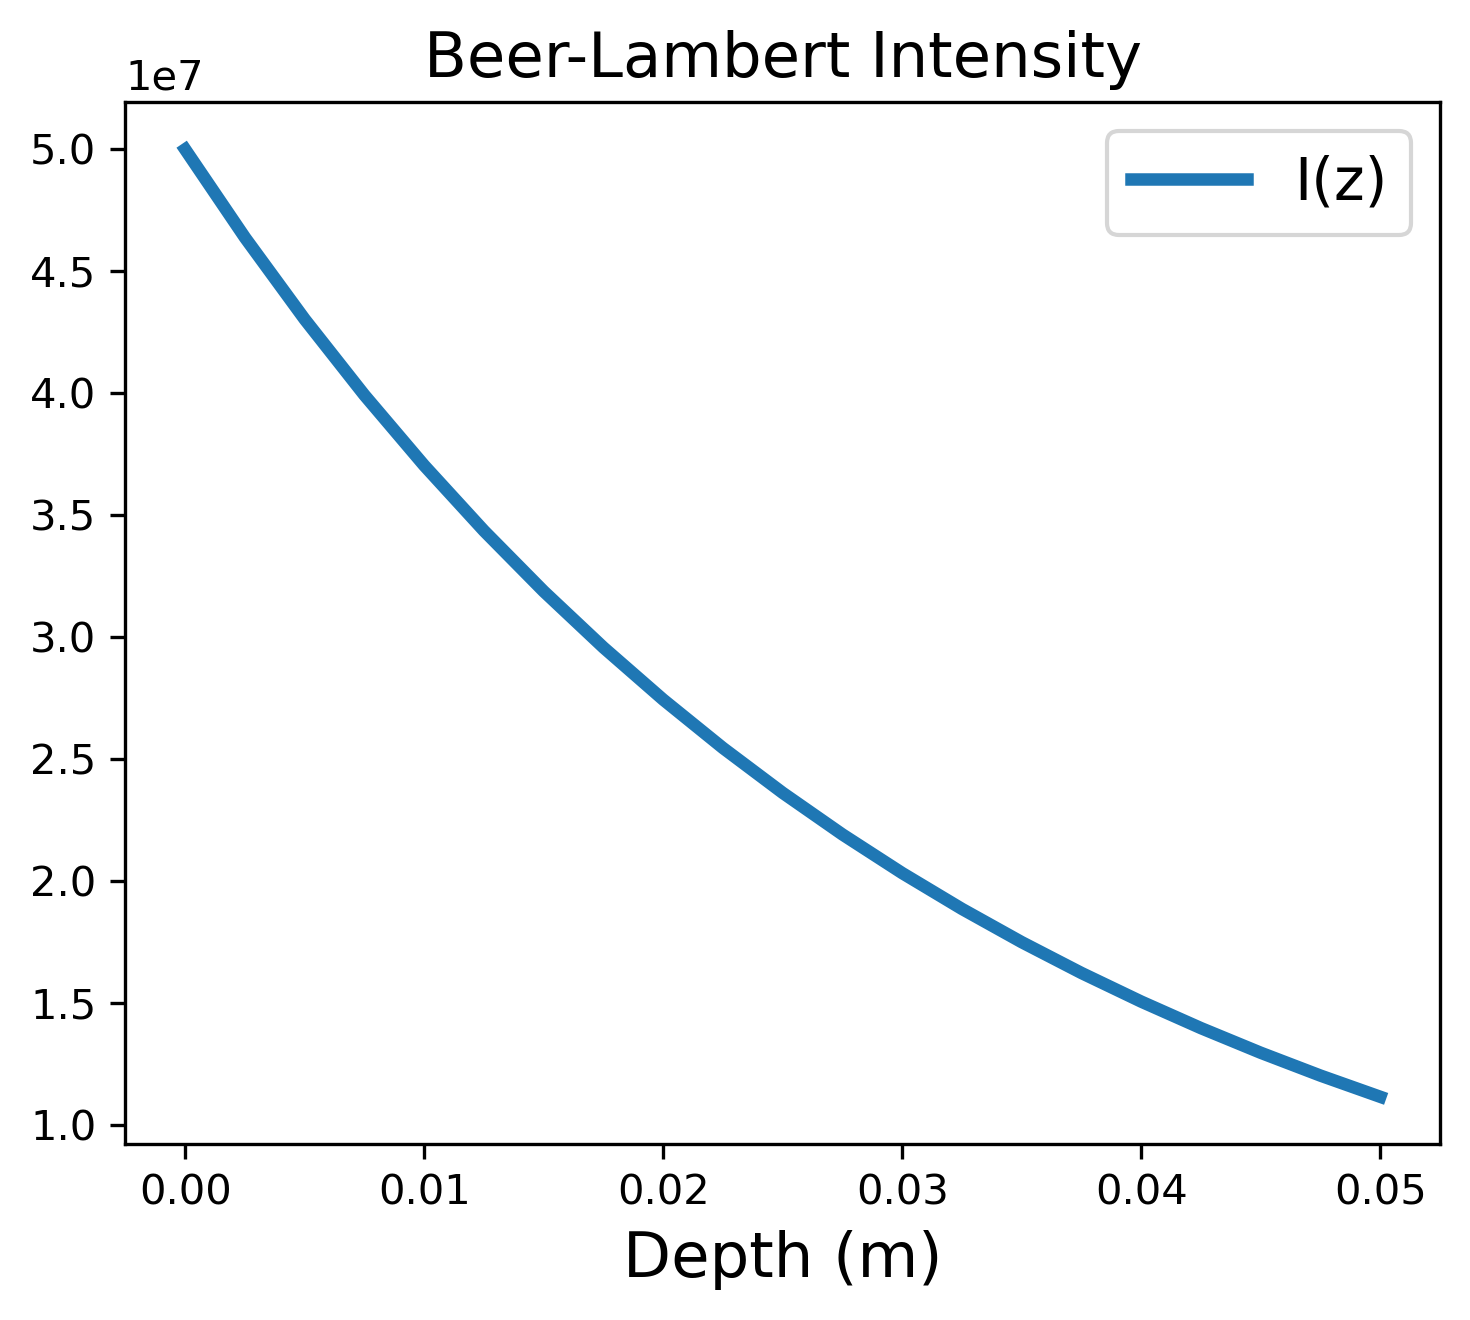

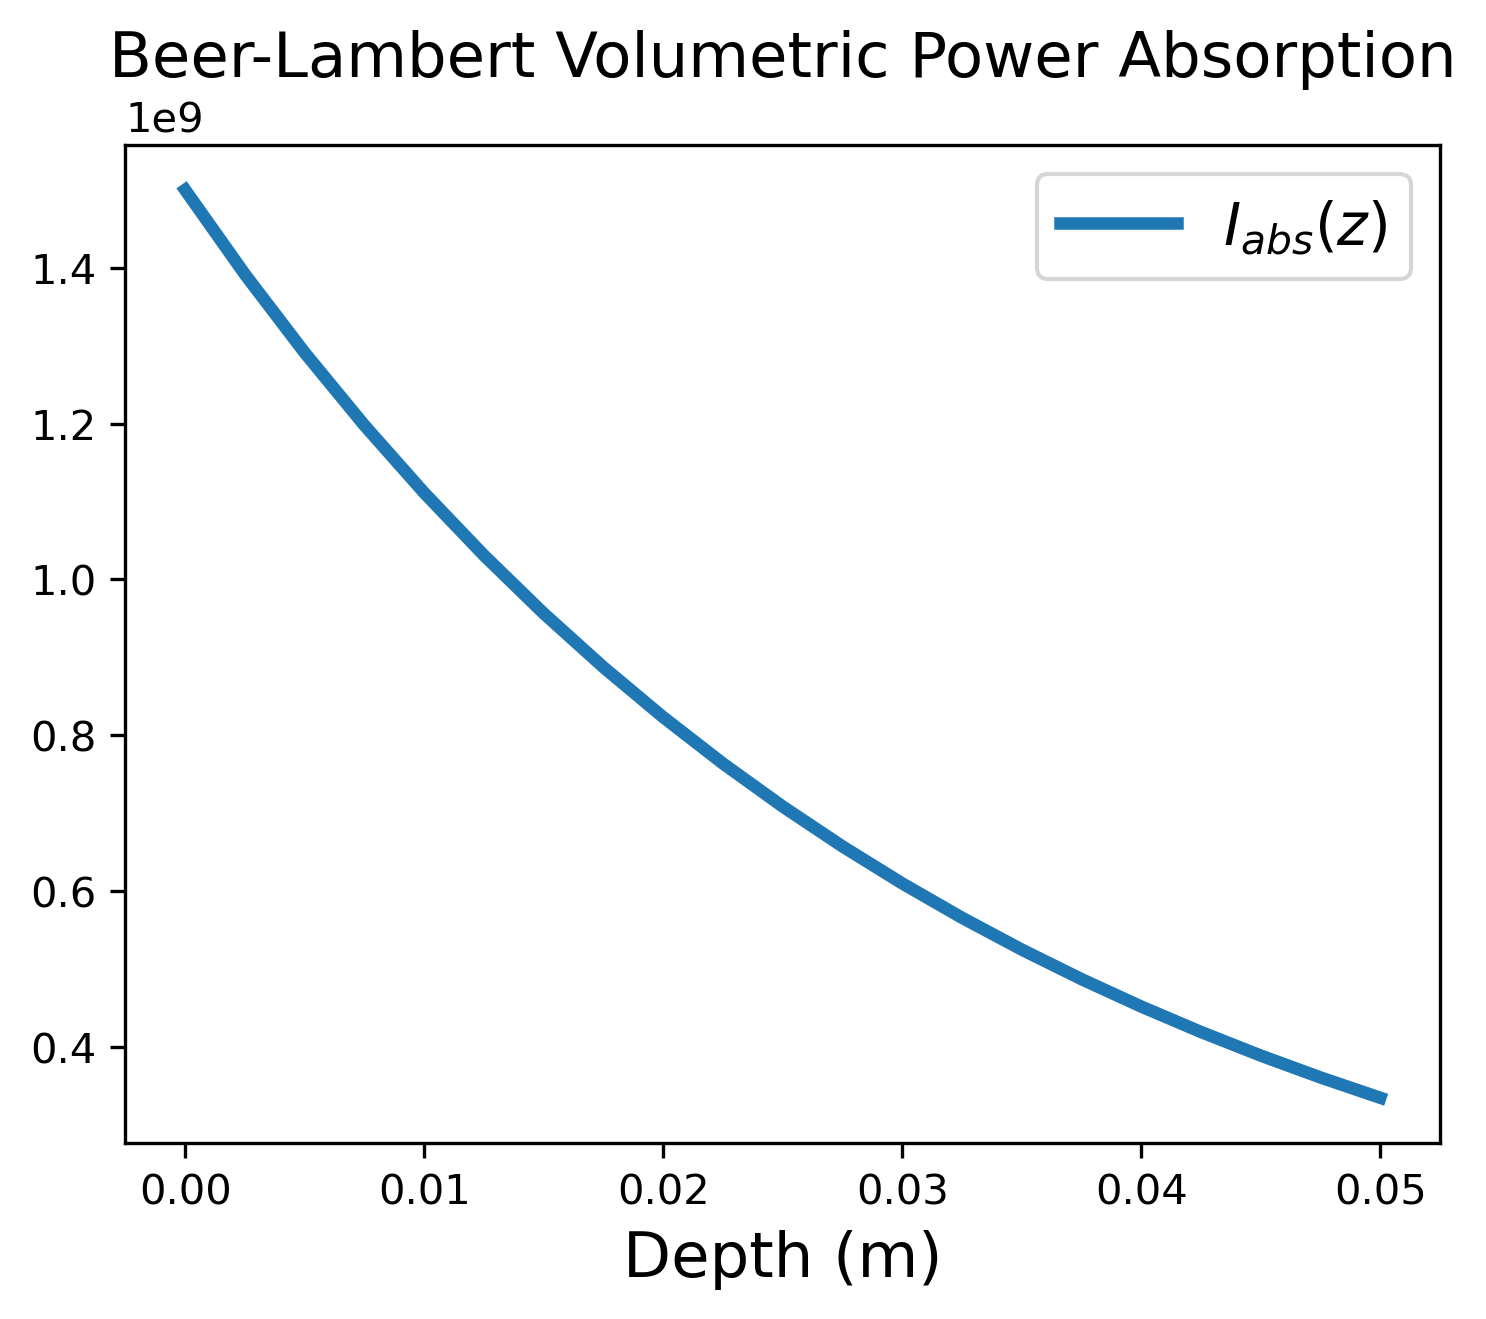

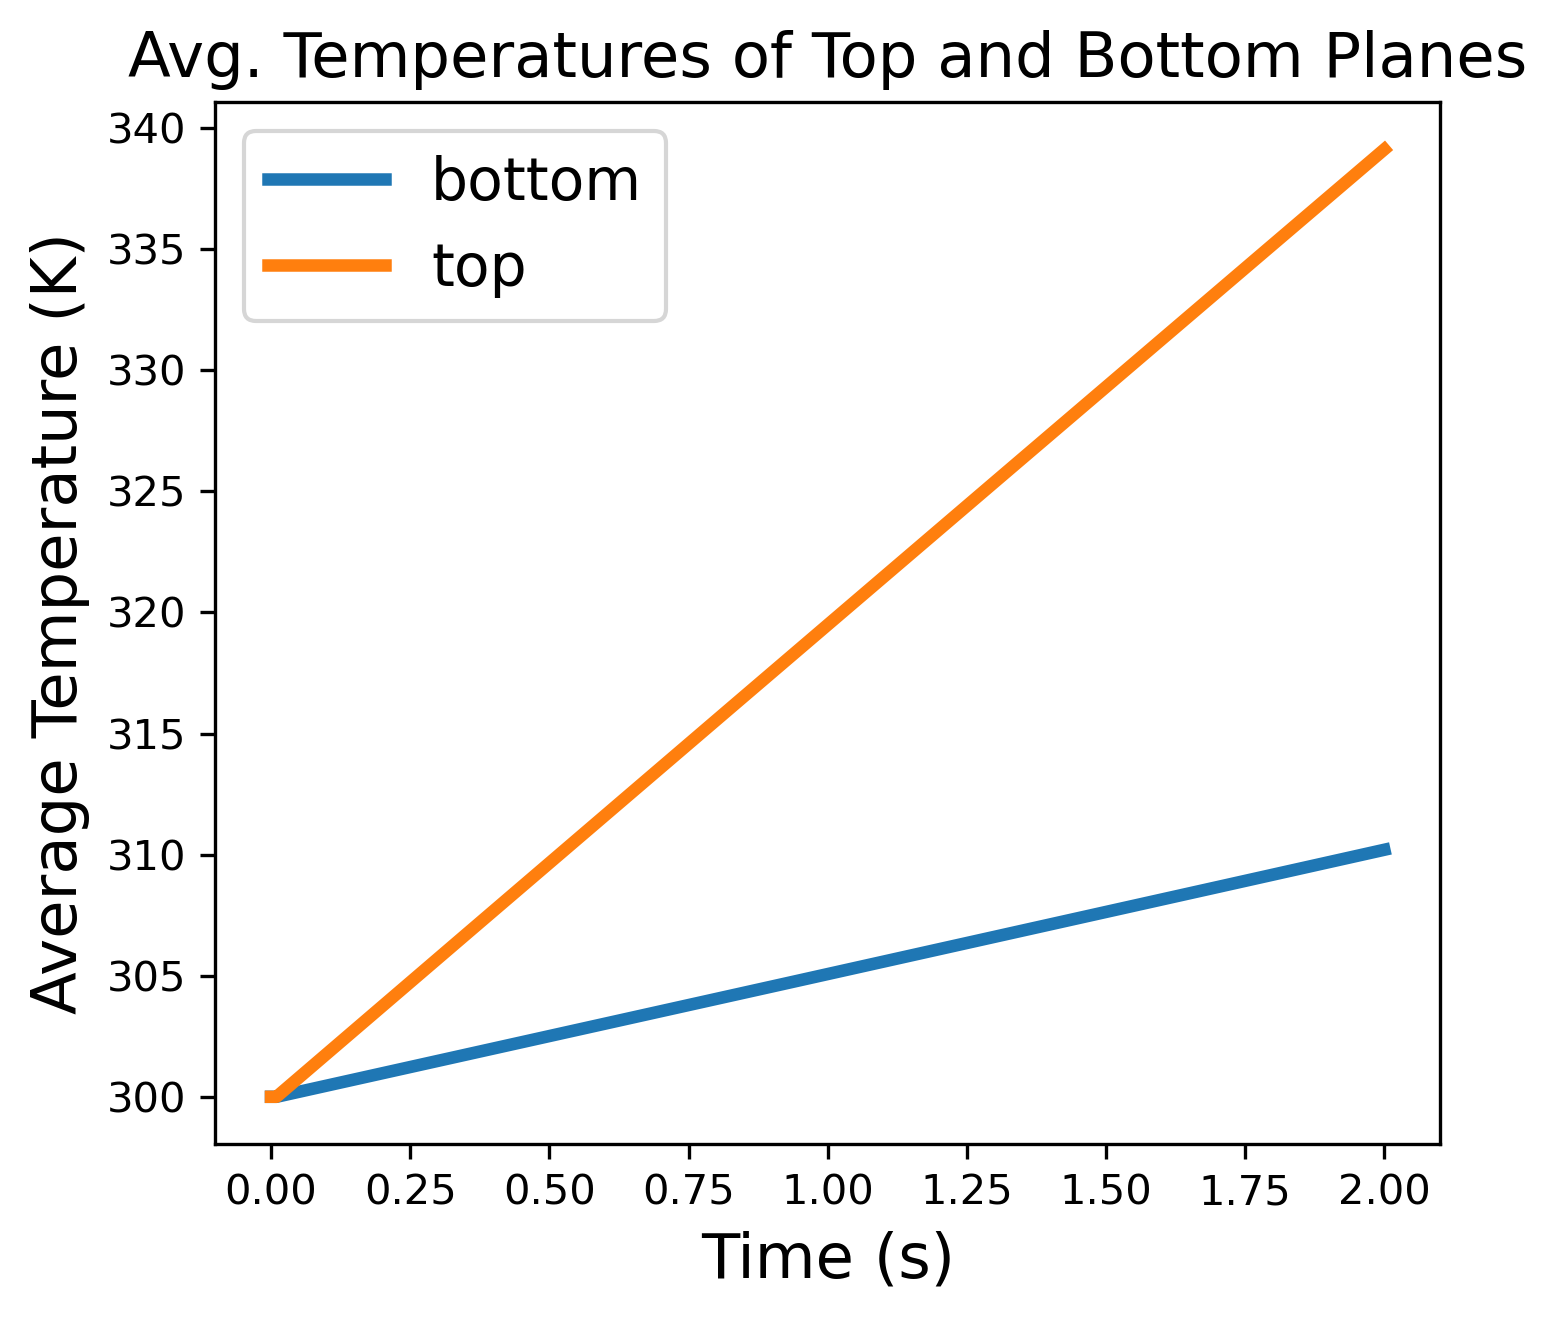

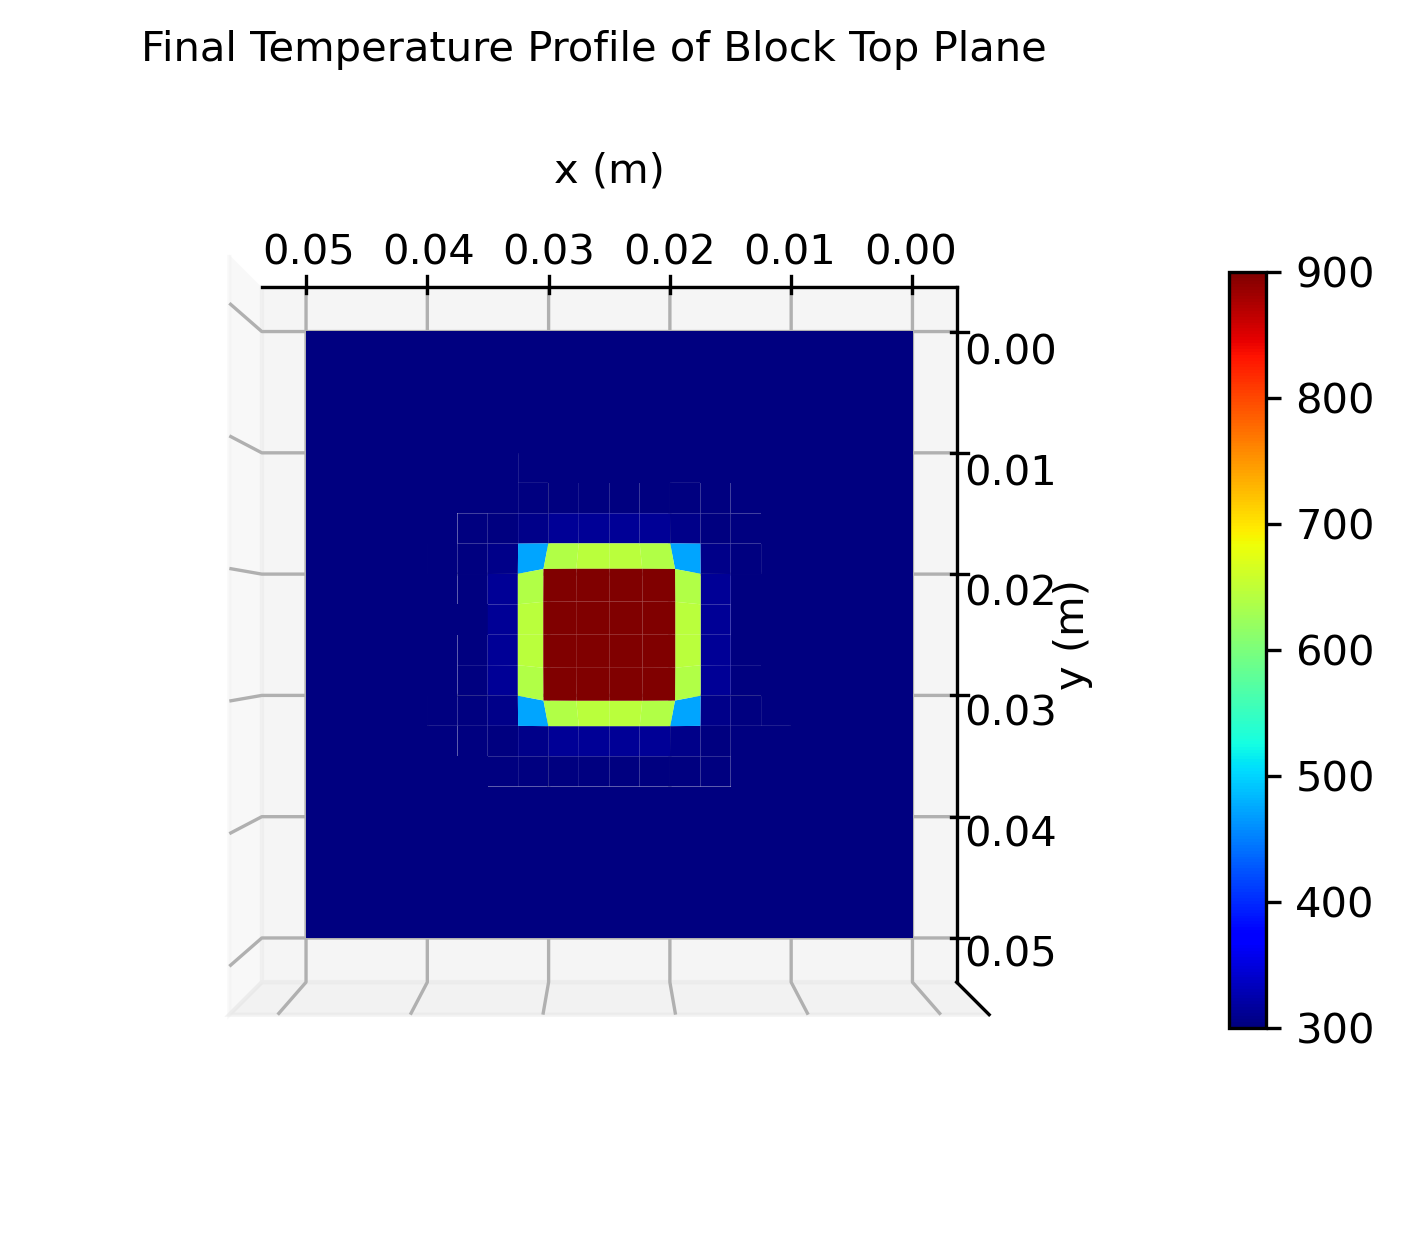

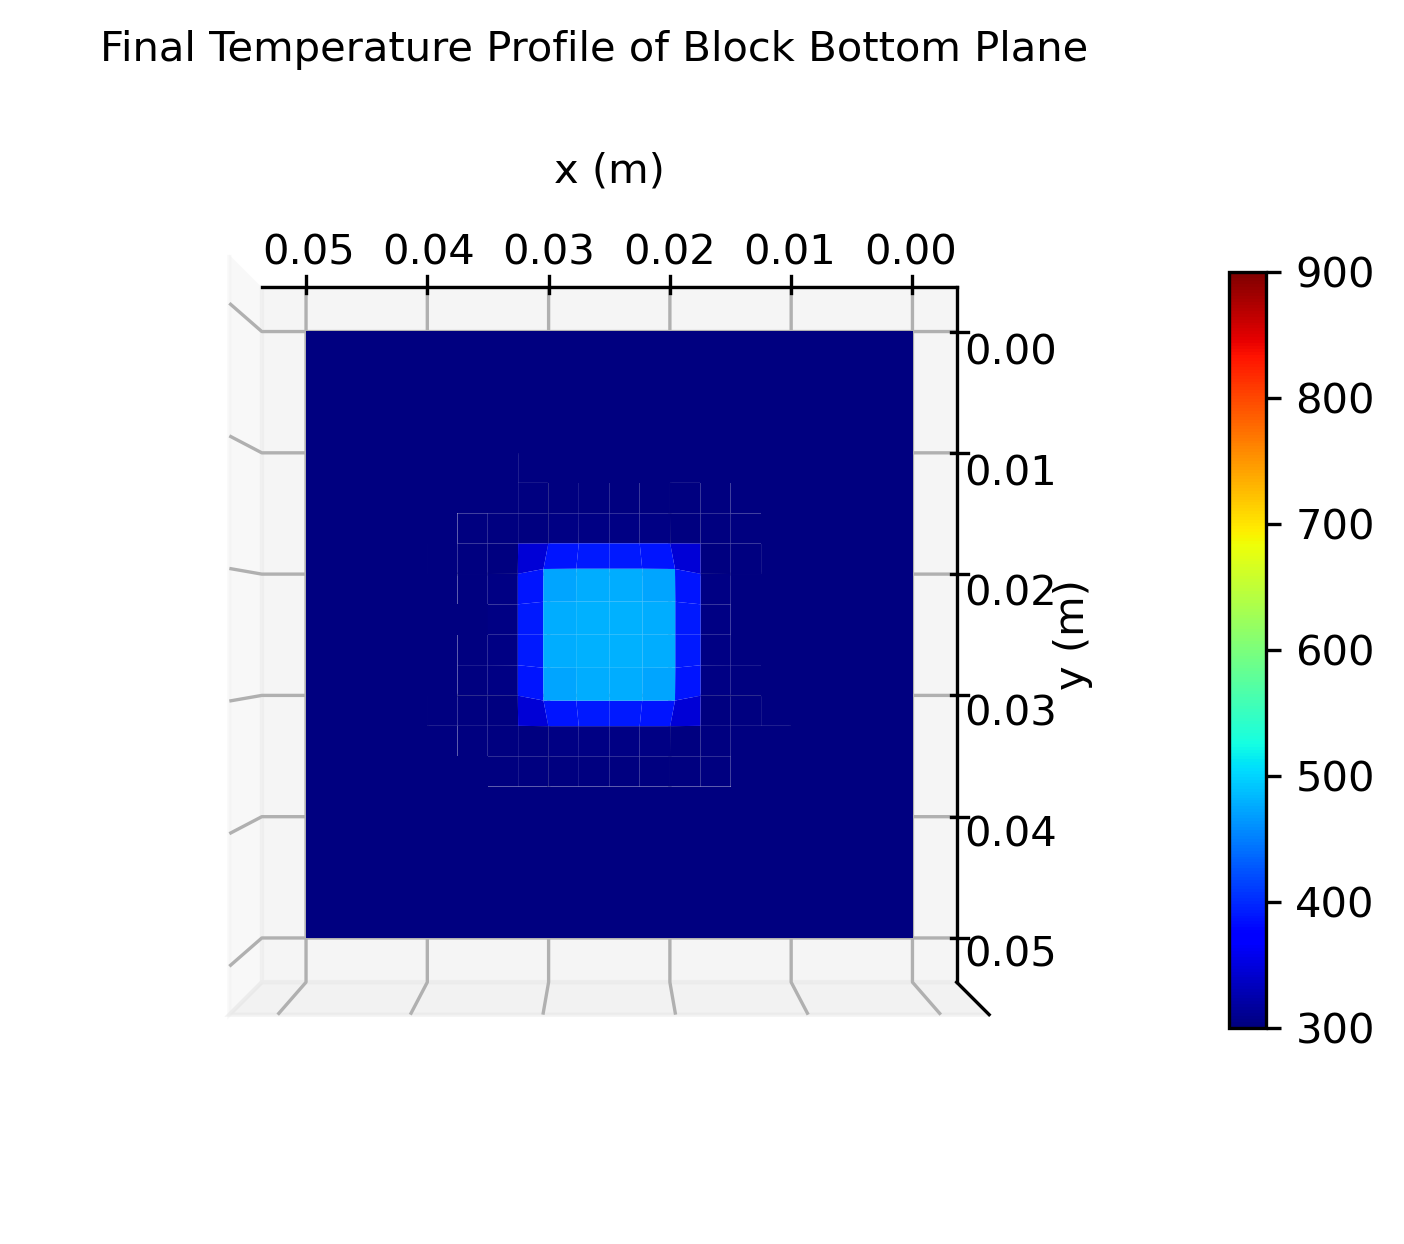

In [6]:
import numpy as np
import scipy
import time
import math
import matplotlib.pyplot as plt
import scipy.interpolate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
from scipy.sparse import csr_matrix

plt.rcParams['animation.embed_limit'] = 2**128

## Setting
#setting = "fig8" #-- applies laser to an lxl square on top of block
#setting = "spy" #sets M=4, shows where helper matrix values are non-zero graphically
#setting = "fig8" # -- applies laser moving in a figure 8 pattern
setting = "default"


## ## Laser Heating of Block of Material ## ##
    
## Assumptions
# - Stress power is negligible i.e. sigma:grad(v) -> 0
# - Deformations are negligible in the material derivative i.e.
#   D(theta)/Dt -> thetadot
# - Energy is only stored as heat (no mechanical work) i.e. all changes
#   in internal energy result in temperature change
# - Fourier's Law holds i.e. all heat flux comes from 
#   internal conduction
# - Constant density i.e. rho(t) = rho0
# - Thermal conductivity is constant and isotropic

## Givens  

# Intensive properties  
rho0 =  8000               # density in reference configuration, [kg/m3]
C = 500                # specific heat capacity, [J/K/kg]
K = 1               # isotropic thermal conductivity, [W/m/K]
a = 30                 # absorption constant, [1/m]   

# Extensive properties
L = 0.05                 # cube dimension, [m]
l = 0.01                # laser dimension, [m]

# Applied settings
I0 = 5e7                # initial laser intensity, [W/m2]
thetaw = 300            # fixed wall temperature, [K]

# Initial Conditions  
theta0 = 300            # initial temperature, [K]

# Time discretization
T = 2                  # final time for simulation, [s]
dt = 10e-3                 # time step, [s]
N  = int(T/dt)+1                 # number of time points, [unitless], value is 201
t  =  np.linspace(0,T,N)              # time points, [s], 1xN

# Space discretization
if setting == "default" or setting == "fig8":
    M = 21            # number of nodes per dimension (9261 nodes total)
elif setting == "spy":
    M = 4             # number of nodes per dimension (64 nodes total)
h = L/(M-1)                  # discritized element size, [m], 0.0025 m

x = np.arange(0, L+h, h)
y = np.arange(0, L+h, h)
z = np.arange(0, L+h, h)

## Construct Mask Arrays

# Construct x-edge/y-edge mask for Dirichlet BCs
dirichlet_mask = np.zeros((M, M, M))
dirichlet_mask[:,  0,  :] = 1 # left  edge (x-edge)
dirichlet_mask[:,  M-1,  :]  = 1 # right edge (x-edge)
dirichlet_mask[:,  :,  0] = 1 # back  edge (y-edge)
dirichlet_mask[:,  :,  M-1] = 1 # front edge (y-edge)

# Construct z-edge mask for Neumann BCs
neumann_mask = np.zeros((M,M,M))
neumann_mask[0,  :,  :] = 1 # bottom edge (z-edge)
neumann_mask[M-1,  :,  :] = 1 # top edge (z-edge)

# Construct mask for obtaining nodes that neighbor Neumann nodes
neumann_neighbors = np.zeros((M,M,M))
neumann_neighbors[1,  :,  :] = 1 # neighbor to a bottom edge
neumann_neighbors[M-2,  :,  :] = 1 # neighbor to a top edge]

if setting == "fig8":
    # Define angle, a function of time that will guide the laser
    frequency = 1/2
    angle = lambda t: 2*np.pi*frequency*t
    laser_nodes = 2 #Don't edit this value

if setting == "default" or setting == "spy":
    # Define laser area
    laser_nodes = int(np.floor(l/h)) + 1 # number of nodes per dimension for the laser

laser_start = int(np.floor((M - laser_nodes)/2))
laser_end = laser_start + laser_nodes

if setting == "default" or setting == "spy":
    laser_mask = np.zeros((M,M,M))
    laser_mask[:, laser_start:laser_end, laser_start:laser_end] = 1

# Reshape masks for application to theta as a vector
dirichlet_mask    = dirichlet_mask.reshape((M**3,))
neumann_mask      = neumann_mask.reshape((M**3,))
neumann_neighbors = neumann_neighbors.reshape((M**3,))
if setting == "default" or setting == "spy":
    laser_mask        = laser_mask.reshape((M**3,))

# Cast masks to logical arrays
dirichlet_mask    = np.array(dirichlet_mask,    dtype=bool)
neumann_mask      = np.array(neumann_mask,      dtype=bool)
neumann_neighbors = np.array(neumann_neighbors, dtype=bool)
if setting == "default" or setting == "spy":
    laser_mask        = np.array(laser_mask,        dtype=bool)

## Initialize storage variables
Tavg_bot = np.ones((N, 1))*theta0  # avg. temperature of the bottom plane
Tavg_top = np.ones((N, 1))*theta0  # avg. temperature of the top plane

# Initialize the temperature in the block
theta =  theta0 * np.ones((M**3,N))

# Define height at each node
height = np.ones((M,M,M))
z_values = np.linspace(0,L,M)
for k in range(M):
    height[k, :, :] = L - z_values[k]
height = height.reshape((M**3,1))

## Construct Second Derivative Helper Matrix, D2
left_neighbors   = np.ones((M**3,1))
right_neighbors  = np.ones((M**3,1))
front_neighbors  = np.ones((M**3,1))
back_neighbors   = np.ones((M**3,1))

# Correct the D2 matrix to account for Dirichlet BCs
D2 = scipy.sparse.lil_matrix((M**3,M**3)) # convert to datatype sparse for speed
D2.setdiag(-6 * np.ones(M**3), k=0)
D2.setdiag(left_neighbors,     k = -1)
D2.setdiag(right_neighbors,    k = 1)
D2.setdiag(back_neighbors,     k = -M)
D2.setdiag(front_neighbors,    k = M)
D2.setdiag(np.ones(M**3),      k = -(M**2)) # downstairs neighbors
D2.setdiag(np.ones(M**3),      k = M**2) # upstairs neighbors

if setting == "spy":
    fig1 = plt.figure(1)
    ax1 = plt.gca()
    plt.spy(D2, marker=".", markersize=6)
    ax1.set_xlabel('Nodes', fontsize=20)
    ax1.set_ylabel('Nodes', fontsize=20)
    ax1.set_title('Laplacian Matrix (4 x 4 x 4)', fontsize=20)
    plt.savefig('spy.png')

else:
    ## Time-stepping through the governing equation

    for n in range(len(t)-1):

        if setting == "fig8":
            # Define laser area
            laser_mask = np.zeros((M,M,M))
            # Figure 8 Equations
            laser_x = np.array(range(laser_start,laser_end+1)) + np.int16(6*np.sin(angle((n+1)*dt))) 
            laser_y = np.array(range(laser_start,laser_end+1)) + np.int16(6*np.sin(2*angle((n+1)*dt))) 
            laser_mask[:,laser_x,laser_y] = 1
            # Reshape masks for application to theta as a vector
            laser_mask = laser_mask.reshape((M**3,))
            # Cast to logical array
            laser_mask = np.array(laser_mask,dtype=bool) 

        # Within this loop n represents a time point
        print(str(n) + ' of ' + str(N))

        # Internal Nodes
        diffusion = (K/h**2)*(D2@theta[:,n]) #part j
        beer_lambert = a * I0 * np.exp(-a*height) #part k
        theta[:,n+1] = theta[:,n] +  dt/(rho0*C) * diffusion
        theta[laser_mask,n+1] = theta[laser_mask,n+1] + dt/(rho0*C) * beer_lambert[laser_mask, 0]

        # Dirichlet Fixed Temp. B.C.s at walls
        theta[dirichlet_mask, n+1] = thetaw

        # Get the values for the nodes with Neumann B.C.s
        neighbors = theta[neumann_neighbors,n]

        # Neumann Insulating B.C.s at top and bottom of block
        theta[neumann_mask, n+1] = neighbors

        # Store average temperatures of top and bottom planes
        Tavg_bot[n+1, 0] = np.mean(theta[0:M**2, n+1]) # z = 0
        Tavg_top[n+1, 0] = np.mean(theta[M**3 - M**2:, n+1]) # z = L #part l


    # Final temp. profile of the top plane
    Tbot = np.reshape(theta[0:M**2,-1], [M, M]) 
    # Final temp. profile of the top plane
    top_start = M**3 - M**2
    Ttop = np.reshape(theta[top_start:,-1],[M, M]) 

    ## DELIVERABLES ##

    ## Beer Lambert energy intensity
    fig2 = plt.figure(2, dpi = 300, figsize = (5,4.5))
    ax2 = plt.gca()
    ax2.plot(z, I0 * np.exp(-a*z), linewidth=3, label='I(z)')
    ax2.set_xlabel('Depth (m)', fontsize=15)
    ax2.set_title('Beer-Lambert Intensity', fontsize=15)
    ax2.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig('beer_lambert_py.png')

    ## Beer Lambert volumetric absorption
    fig3 = plt.figure(3, dpi = 300, figsize = (5,4.5))
    ax3 = plt.gca()
    ax3.plot(z, a * I0 * np.exp(-a*z), linewidth=3, label='$I_{abs}(z)$')
    ax3.set_xlabel('Depth (m)', fontsize=15)
    #ax3.set_ylabel('Volumetric Power Absorption ($W/m^3$)', fontsize=20)
    ax3.set_title('Beer-Lambert Volumetric Power Absorption', fontsize=15)
    ax3.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig('beer_lambert_vol_py.png')

    ## Average of top and bottom plane
    fig4 = plt.figure(4, dpi = 300, figsize = (5,4.5))
    ax4 = plt.gca()
    t = t.reshape(-1,1)
    ax4.plot(t, Tavg_bot, linewidth=3, label='bottom')
    ax4.plot(t, Tavg_top, linewidth=3, label='top')
    ax4.set_xlabel('Time (s)', fontsize=15)
    ax4.set_ylabel('Average Temperature (K)', fontsize=15)
    ax4.set_title('Avg. Temperatures of Top and Bottom Planes', fontsize=15)
    ax4.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig('avg_temp_py.png')

    ## 2D grid of the temperatures at the top plane (final time)
    fig5 = plt.figure(5, dpi = 300, figsize = (5,4.5))
    ax5 = fig5.add_subplot(111, projection='3d')
    [xq, yq] = np.meshgrid(x, y)
    if setting == "default":
        surf = ax5.plot_surface(yq, xq, Ttop, cmap='jet', vmin=300, vmax=900)
    elif setting == "fig8":
        surf = ax5.plot_surface(yq, xq, Ttop, cmap='jet', vmin=300, vmax=400)
    ax5.set_title('Final Temperature Profile of Block Top Plane', fontsize=10)
    ax5.set_xlabel('x (m)', fontsize=10)
    ax5.set_ylabel('y (m)', fontsize=10)
    ax5.view_init(elev=90, azim=90)
    ax5.set_zticks([])
    c = plt.colorbar(surf, shrink = 0.6)
    c.label = 'Temperature (K)'
    plt.tight_layout()
    plt.savefig('top_plane_end_temp_py.png')

    ## 2D grid of the temperatures in the bottom plane (final time)
    fig6 = plt.figure(6, dpi = 300, figsize = (5,4.5))
    ax6 = fig6.add_subplot(111, projection='3d')
    [xq, yq] = np.meshgrid(x, y)
    if setting == "default":
        surf = ax6.plot_surface(yq, xq, Tbot, cmap='jet', vmin=300, vmax=900)
    elif setting == "fig8":
        surf = ax6.plot_surface(yq, xq, Tbot, cmap='jet', vmin=300, vmax=400)
    ax6.set_title('Final Temperature Profile of Block Bottom Plane', fontsize=10)
    ax6.set_xlabel('x (m)', fontsize=10)
    ax6.set_ylabel('y (m)', fontsize=10)
    ax6.view_init(elev=90, azim=90)
    ax6.set_zticks([])
    c = plt.colorbar(surf, shrink = 0.6)
    c.label = 'Temperature (K)'
    plt.tight_layout()
    plt.savefig('bottom_plane_end_temp_py.png')
    print(Tavg_top[-1])
    print(Tavg_bot[-1])

